## Fetch the Data and Visualize Data

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

# # Fetch Data
# data = pd.read_csv('data-sets/air_passengers.csv')

# month = data['Month']
# passengers = data['Passengers']

# plt.plot(month, passengers)
# plt.xlabel('month')
# plt.ylabel('passengers')
# plt.title('Air Passengers')
# plt.show()

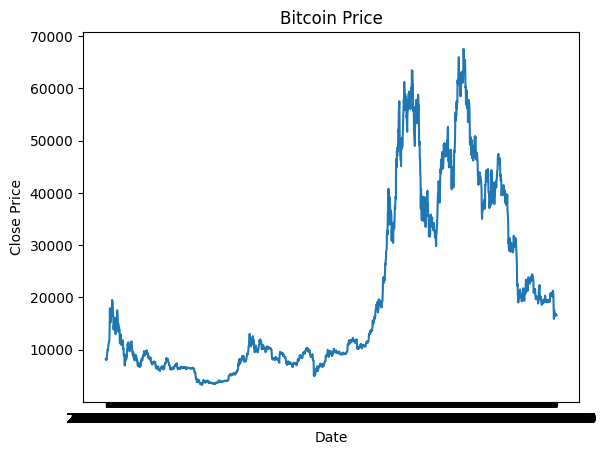

In [129]:
data = pd.read_csv('data-sets/BTC-USD-5Y.csv')
date = data['Date']
close = data['Close']

plt.plot(date, close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Bitcoin Price')
plt.show()

## Clean trend and seasonality from data

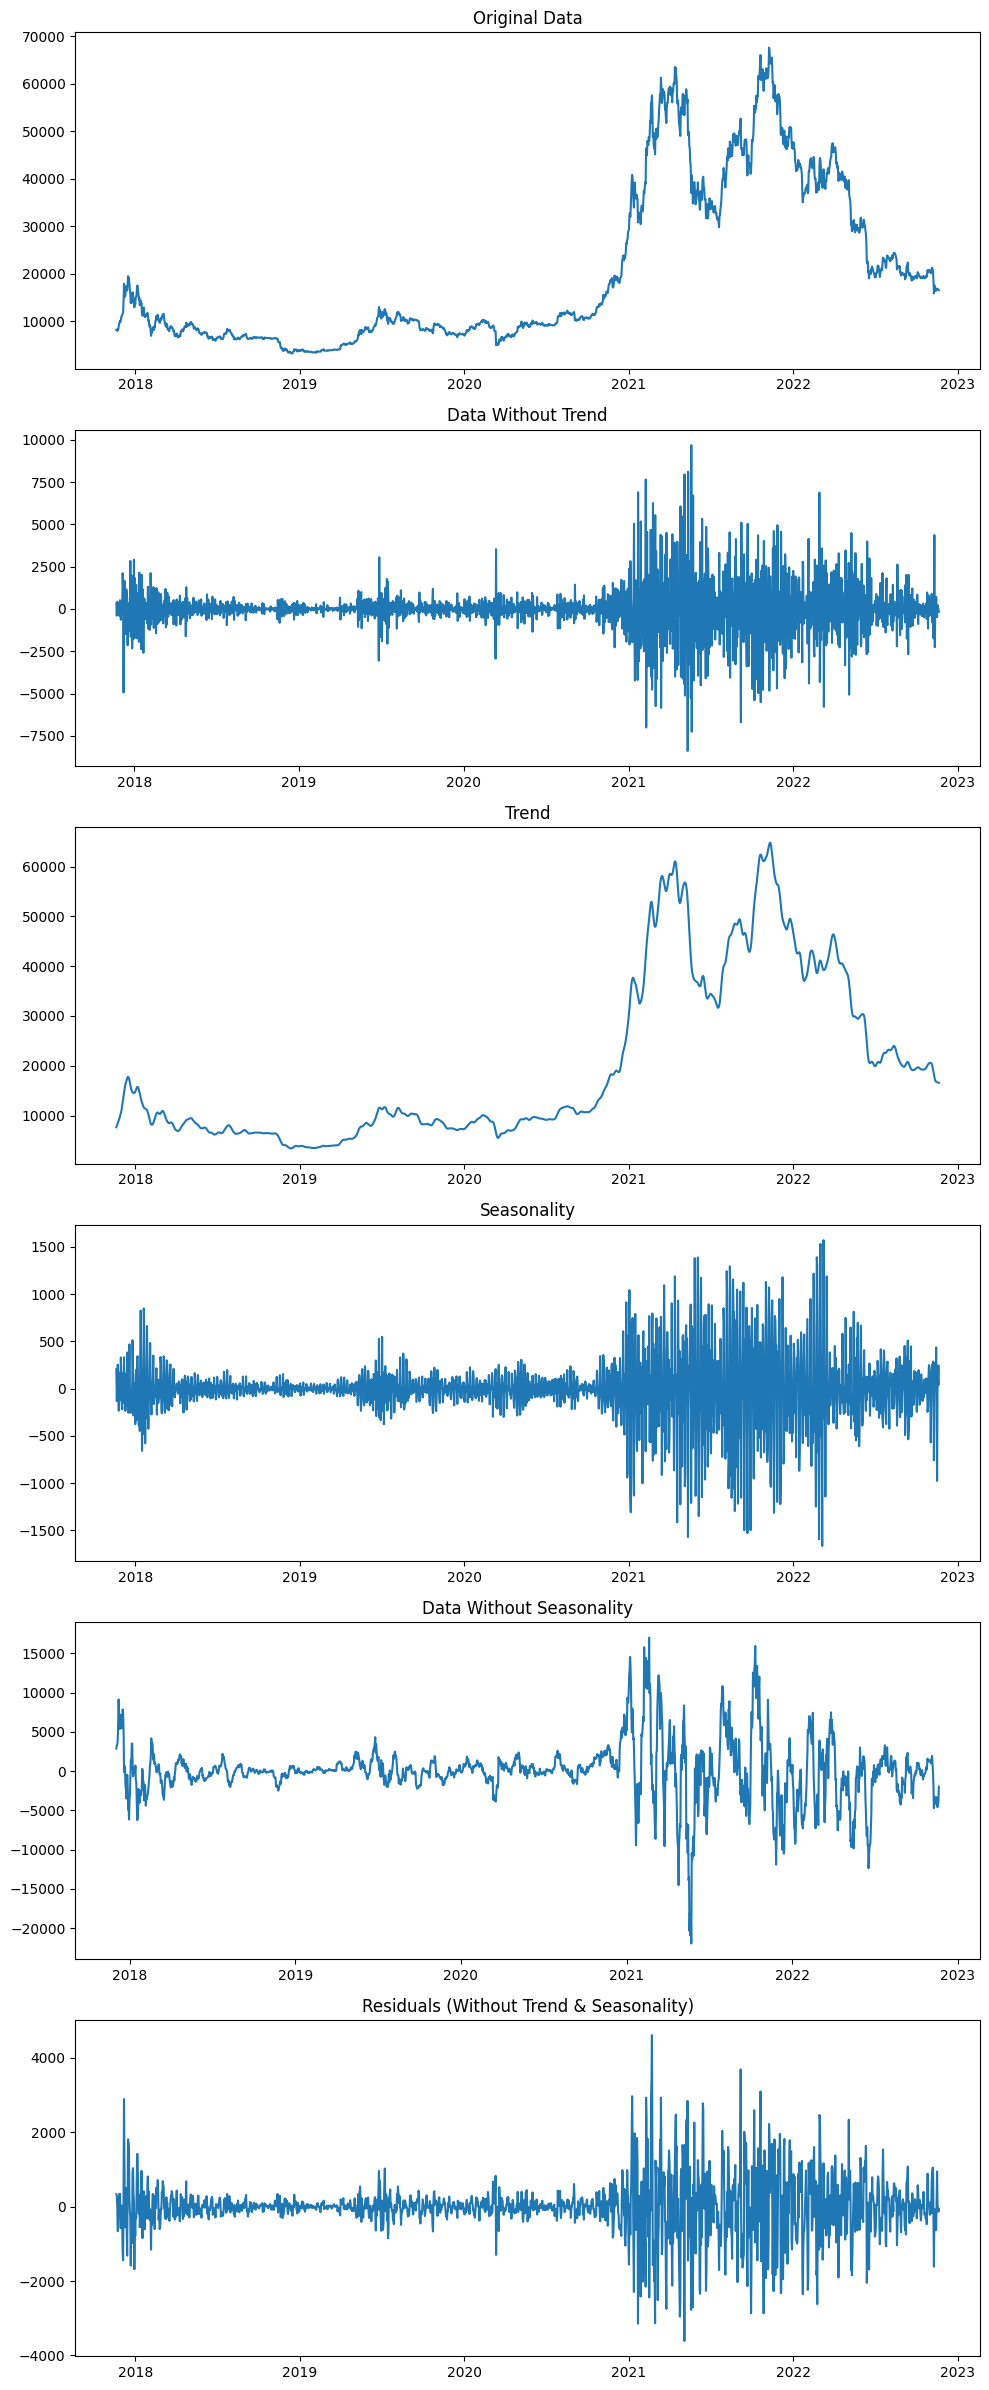

In [130]:
from statsmodels.tsa.seasonal import STL

# Data has a datetime column, set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Perform seasonal decomposition
decomp = STL(data['Close']).fit()

# Obtain the trend, seasonal, and residual components

# d = 2
data_without_trend = data['Close'].diff().diff()
trend = decomp.trend

# seasonality = 12
seasonal_period = 12
data_without_seasonality = data['Close'].diff(periods=seasonal_period)
seasonal = decomp.seasonal

residuals = decomp.resid
residuals_df = pd.DataFrame({'residuals': residuals})

# p = 2
residuals_df['t-1'] = residuals_df['residuals'].shift(1).values
residuals_df['t-2'] = residuals_df['residuals'].shift(2).values
residuals_df = residuals_df.dropna()

# Plot the original data, trend, and seasonality
plt.figure(figsize=(10, 24))

plt.subplot(6, 1, 1)
plt.plot(data['Close'])
plt.title('Original Data')

plt.subplot(6, 1, 2)
plt.plot(data_without_trend)
plt.title('Data Without Trend')

plt.subplot(6, 1, 3)
plt.plot(trend)
plt.title('Trend')

plt.subplot(6, 1, 4)
plt.plot(seasonal)
plt.title('Seasonality')

plt.subplot(6, 1, 5)
plt.plot(data_without_seasonality)
plt.title('Data Without Seasonality')

plt.subplot(6, 1, 6)
plt.plot(residuals)
plt.title('Residuals (Without Trend & Seasonality)')

plt.tight_layout()
plt.show()

## We will continue with the residuals data

In [131]:
import numpy as np

data = data.reset_index(drop=True)
residuals_df = residuals_df.reset_index(drop=True)

In [132]:
train_size = int(len(residuals_df) * 0.80)
test_size = int(len(residuals_df) * 0.20)


train_data = residuals_df[:train_size]
test_data = residuals_df[train_size:]

In [133]:
from sklearn import linear_model

X_train = train_data[['t-1', 't-2']]
y_train = train_data['residuals']

model = linear_model.LinearRegression()

In [134]:
from sklearn.model_selection import KFold, GridSearchCV
from skopt.plots import plot_objective, plot_histogram
import skopt

# Decleartions for deprecated functions in numpy
np.float = float    
np.int = int    
np.object = object    
np.bool = bool    

# Define hyperparameters for bayesian optimization
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
    }


kFold = KFold(n_splits=100, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv= kFold, n_jobs=-1, 
                             scoring='neg_mean_absolute_percentage_error')

grid_search.fit(X_train, y_train)

# Print the cross validation results
cv_results = grid_search.cv_results_
cv_results_df = pd.DataFrame(cv_results)

cv_results_df['fit_intercept'] = cv_results_df['params'].apply(lambda x: x['fit_intercept'])
cv_results_df['copy_X'] = cv_results_df['params'].apply(lambda x: x['copy_X'])


print(cv_results_df[['mean_test_score', 'fit_intercept', 'copy_X']])

# plot_objective creates pairwise dependence plot of the objective function.
# plot_objective(bayes_search.optimizer_results_[0],
#                    dimensions=["C", "gamma", "epsilon"],
#                    n_minimum_search=int(1e8))

# Print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

best_model = grid_search.best_estimator_


   mean_test_score  fit_intercept  copy_X
0        -2.150121           True    True
1        -2.143315          False    True
2        -2.150121           True   False
3        -2.143315          False   False
Best hyperparameters: {'copy_X': True, 'fit_intercept': False}


In [135]:
import matplotlib.pyplot as plt

X_test = test_data[['t-1', 't-2']]
y_test = test_data['residuals']


best_model.fit(X_train, y_train)
y_pred_resid = best_model.predict(X_test)


print(y_pred_resid - y_test)

1460     624.740466
1461    1639.545135
1462    -931.144726
1463    1231.234612
1464   -1271.338375
           ...     
1820    -803.247065
1821     363.722754
1822     -53.447067
1823     105.062453
1824      10.264989
Name: residuals, Length: 365, dtype: float64


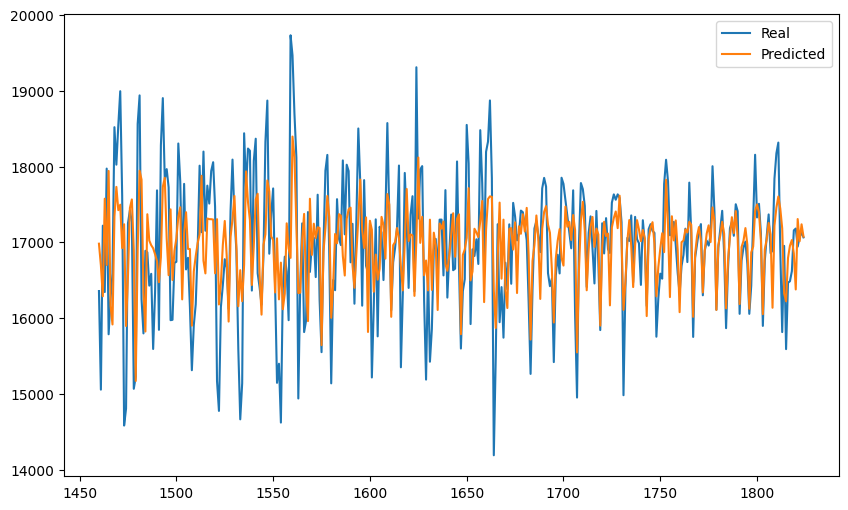

In [136]:
# Our seasonality is yearly (12 months)
seasonal_period = 12 

# Extend the last known value of the trend into the future.
last_known_trend = trend[-seasonal_period:].mean()

# trend_test = np.full(len(X_test), last_known_trend)

# Repeat the last complete seasonal cycle for future periods.
last_seasonal_cycle = seasonal[-seasonal_period:]
seasonal_test = np.tile(last_seasonal_cycle, len(X_test) // seasonal_period + 1)[:len(X_test)]


# Add back the trend and seasonal components.
y_pred = y_pred_resid + last_known_trend + seasonal_test
y_test = y_test + last_known_trend + seasonal_test 

# Plotting
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

In [137]:
from sklearn.metrics import mean_absolute_percentage_error

mse = mean_absolute_percentage_error(y_test, y_pred)
print('Mean Squared Error on test set:', mse)

Mean Squared Error on test set: 0.03245026827531171
